In [1]:
import functools as ft
import re

import numpy as np
import matplotlib.pylab as plt

import outlines.models as models
import outlines.text as text

In [13]:
%env OPENAI_API_KEY= # you key here

env: OPENAI_API_KEY=# you key here


In this example we will look at completion results for questions from the GSM8K dataset, using few-shots prompts with 5 examples. We first use `outlines.text.prompt` to build the few-shot prompt. `outlines.text.prompt` is a decorator around "prompt functions" which contain the prompt template in its docstring. Outlines uses the Jinja2 templating engine to render the prompt when the function is called with the variables' values; it thus allows you to build complex prompts very easily.

In [3]:
examples = [
    {
        "question": "There are 15 trees in the grove. Grove workers will plant trees in the grove today. After they are done, there will be 21 trees. How many trees did the grove workers plant today?",
        "answer": "We start with 15 trees. Later we have 21 trees. The difference must be the number of trees they planted. So, they must have planted 21 - 15 = 6 trees. The answer is 6.",
    },
    {
        "question": "If there are 3 cars in the parking lot and 2 more cars arrive, how many cars are in the parking lot?",
        "answer": "There are 3 cars in the parking lot already. 2 more arrive. Now there are 3 + 2 = 5 cars. The answer is 5.",
    },
    {
        "question": "Leah had 32 chocolates and her sister had 42. If they ate 35, how many pieces do they have left in total?",
        "answer": "Leah had 32 chocolates and Leah’s sister had 42. That means there were originally 32 + 42 = 74 chocolates. 35 have been eaten. So in total they still have 74 - 35 = 39 chocolates. The answer is 39.",
    },
    {
        "question": "Jason had 20 lollipops. He gave Denny some lollipops. Now Jason has 12 lollipops. How many lollipops did Jason give to Denny?",
        "answer": "Jason had 20 lollipops. Since he only has 12 now, he must have given the rest to Denny. The number of lollipops he has given to Denny must have been 20 - 12 = 8 lollipops. The answer is 8.",
    },
    {
        "question": "Shawn has five toys. For Christmas, he got two toys each from his mom and dad. How many toys does he have now?",
        "answer": "He has 5 toys. He got 2 from mom, so after that he has 5 + 2 = 7 toys. Then he got 2 more from dad, so in total he has 7 + 2 = 9 toys. The answer is 9.",
    },
    {
        "question": "There were nine computers in the server room. Five more computers were installed each day, from monday to thursday. How many computers are now in the server room?",
        "answer": "There are 4 days from monday to thursday. 5 computers were added each day. That means in total 4 * 5 = 20 computers were added. There were 9 computers in the beginning, so now there are 9 + 20 = 29 computers. The answer is 29.",
    },
    {
        "question": "Michael had 58 golf balls. On tuesday, he lost 23 golf balls. On wednesday, he lost 2 more. How many golf balls did he have at the end of wednesday?",
        "answer": "Michael initially had 58 balls. He lost 23 on Tuesday, so after that he has 58 - 23 = 35 balls. On Wednesday he lost 2 more so now he has 35 - 2 = 33 balls. The answer is 33.",
    },
    {
        "question": "Olivia has $23. She bought five bagels for $3 each. How much money does she have left?",
        "answer": "She bought 5 bagels for $3 each. This means she spent 5",
    },
]

@text.prompt
def few_shot_prompt(question, examples):
    """
    {% for example in examples %}
    Q: {{ example.question }}
    A: {{ example.answer }}
    {% endfor %}
    Q: {{ question }}
    A:
    """

# Prompt functions can be partially evaluated like any other function
gsm8k_prompt = ft.partial(few_shot_prompt, examples=examples)

## When `text-davinci-003` is uncertain

Let us now sample 20 completions with the `text-davinci-003` model. Outlines is sampling first, and allows to draw several samples with both OpenAI and `transformers` models easily:

In [4]:
model = models.text_completion.openai("text-davinci-003", max_tokens=128)

question = "When I was 6 my sister was half my age. Now I’m 70 how old is my sister?"
prompt = gsm8k_prompt(question)
answers = model(prompt, samples=20)

The correct answer to this question is 67. Let us now count the different answers, and take a look at their distribution. Let us first define a few utility functions:

In [5]:
def count_digits(answers):
    digits = []
    for answer in answers:
        try:
            match = re.findall(r"\d+", answer)[-1]
            if match is not None:
                digit = int(match)
                digits.append(digit)
        except AttributeError:
            print(f"Could not parse the completion: '{answer}'")
    
    unique_digits, counts = np.unique(digits, return_counts=True)
    return {d: c for d, c in zip(unique_digits, counts)}

def plot_counts(counts):
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111)
    
    bar = ax.bar(counts.keys(), counts.values())
    ax.spines[["right", "top", "left"]].set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    for rect in bar:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.0f}', ha='center', va='bottom', fontsize=20)
    
    ax.set_xticks(list(counts.keys()))
    ax.set_xlabel("Answer")

def entropy(counts):
    counts = np.array(list(counts.values()))
    probs = counts / np.sum(counts)
    log_probs = np.log(probs)
    return - np.sum(probs * log_probs)

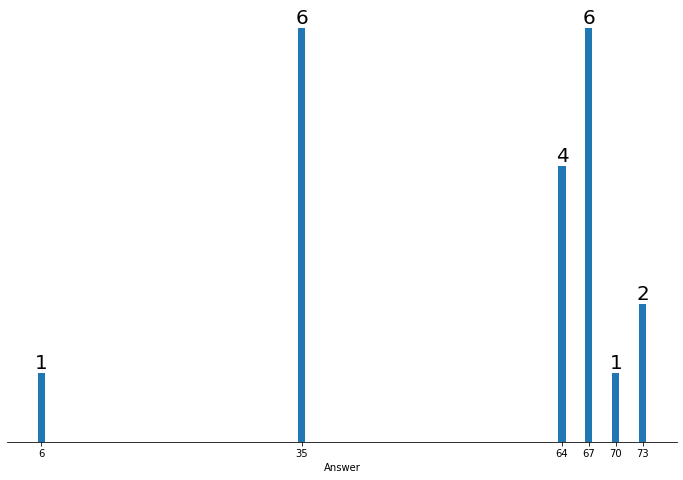

In [6]:
counts = count_digits(answers)
plot_counts(counts)

We see that there is an important variabilty in the answers given by `text-davinci-003`. Depending on the number of samples taken, even self-consistency sampling may lead to the wrong result here.

In [7]:
print(f"Entropy: {entropy(counts)}")

Entropy: 1.5741030017371853


## `text-davinci-003` on an easier question

Let us now look at the results for an arguably easier question:

In [8]:
question = "John buys 2 pairs of shoes for each of his 3 children. They cost $60 each. How much did he pay?"
prompt = gsm8k_prompt(question)
answers = model(question, samples=20)

Entropy: 0.1985152433458726


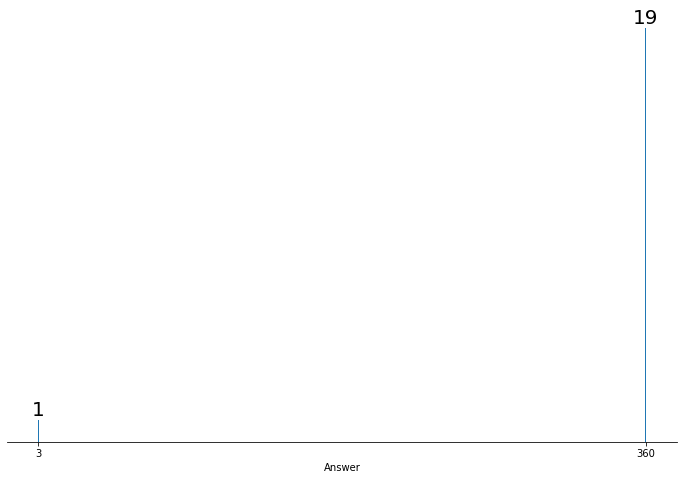

In [9]:
counts = count_digits(answers)
plot_counts(counts)
print(f"Entropy: {entropy(counts)}")

The entropy of the results is much lower, we say that the model is more "certain" of its answers. 

## How `gpt-4` compares to `text-davinci-003`

Let us now look at how GPT4 fares on the original question:

In [11]:
model = models.text_completion.openai("gpt-4", max_tokens=128)

question = "When I was 6 my sister was half my age. Now I’m 70 how old is my sister?"
prompt = gsm8k_prompt(question)
answers = model(prompt, samples=20)

Entropy: -0.0


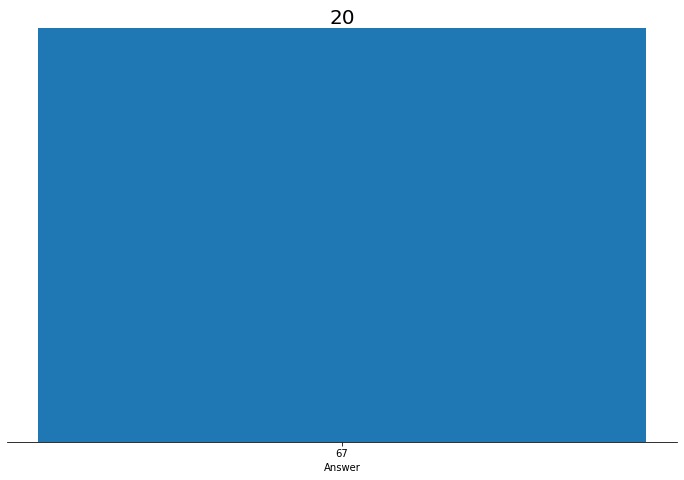

In [12]:
counts = count_digits(answers)
plot_counts(counts)
print(f"Entropy: {entropy(counts)}")

GPT4 returns the correct answer with certainty.

## Conclusion

When generating text completions with a language model we typically look at one output sample, trying to find the "right" answer. However, doing so we obscure the diversity of answers that these language models can produce. Assuming the diversity of answers reflects these models' "uncertainty", we can use measures such as the entropy of the answers' distribution to evaluate the quality of the answer.

Which result should we be choosing once we have different samples? There is no definite answer to this question. The [self-consistency method](https://arxiv.org/abs/2203.11171) consists in choosing the result based on a majority vote. We think this choice is arbitrary and that choosing the correct answer is a [decision theory](https://en.wikipedia.org/wiki/Decision_theory) problem, which can only be solved by specifying a loss function that is adapted to the experiment's context; the majority vote being a particular case with a 0-1 loss.